In [2]:
print("hello")

hello


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import os

In [14]:
carData_filepath = "C:/Users/PORTATIL/OneDrive/Documentos/Projects/CochecitosScrapping/OldOutputData/coches_data_compiled_2025-02-22_01-14.parquet"

# Load dataset
df1 = pd.read_parquet(carData_filepath)
print(df1.columns)
df1 = df1.drop(columns=['Scrape Date'])
print(df1.describe())

carData2_filepath = "C:/Users/PORTATIL/OneDrive/Documentos/Projects/CochecitosScrapping/OutputData/coches_data_consolidado_2025-02-19_17-27.parquet"

df2 = pd.read_parquet(carData2_filepath)
print(df2.columns)
print(df2.describe())


df = pd.concat([df1, df2], axis=0, ignore_index=True)
df = df.dropna()


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/PORTATIL/OneDrive/Documentos/Projects/CochecitosScrapping/OldOutputData/coches_data_compiled_2025-02-22_01-14.parquet'

Combined dataframe. This should be done with lists for faster performance, not the dataframes themselves.

In [4]:
folder_path = "C:/Users/PORTATIL/OneDrive/Documentos/Projects/CochecitosScrapping/OutputData"
# Get all text files in the folder
files = [f for f in os.listdir(folder_path) if f.endswith(".parquet")]

    # List to store scraped data
df = pd.DataFrame()

    # Loop through each file
for file in files:
    file_path = os.path.join(folder_path, file)
        
    df1 = pd.read_parquet(file_path)

    df = pd.concat([df, df1], axis=0, ignore_index=True)

In [5]:
df.describe()

,Title,Price,Features,URL,Scrape Date,Source File
count,45917,45917,45917,45917,45917,45917
unique,12879,3472,38109,38403,4,20
top,VOLKSWAGEN Golf,13.990 €,"2020, 55.249 km, Alicante, Berlina, Cambio Man...",https://www.coches.net/mini-mini-one-5-puertas...,2025-02-23,car_links_2025-02-23_19-08.txt
freq,154,377,83,84,36653,5705


In [6]:
# Split features into separate columns
df["FeaturesList"] = df["Features"].str.split(", ")
features_df = df["FeaturesList"].apply(pd.Series)

#concatenate back the desired features
df = pd.concat([df, features_df.iloc[:, [0, 1]]], axis=1)
df = df.rename(columns={1: "KM", 0: "YEAR"})


In [7]:
# Split features into separate columns
df["BrandModel"] = df["Title"].str.split(" ")
features_df = df["BrandModel"].apply(pd.Series)

#concatenate back the desired features
df = pd.concat([df, features_df.iloc[:, [0, 1]]], axis=1)
df = df.rename(columns={1: "Model", 0: "Brand"})

print(df.columns)


Index(['Title', 'Price', 'Features', 'URL', 'Scrape Date', 'Source File',
       'FeaturesList', 'YEAR', 'KM', 'BrandModel', 'Brand', 'Model'],
      dtype='object')


In [8]:
# Clean and convert YEAR column
df["YEAR"] = (
    df["YEAR"]
    .astype(str)  # Ensure it's a string
    .str.strip()  # Remove leading/trailing spaces
    .replace("", np.nan)  # Convert empty strings to NaN
    .dropna()  # Remove NaN values
    .astype(int)  # Convert to integer
)

# Convert price to integer (removing non-digit characters)
df["PriceInt"] = (
    df["Price"].astype(str)
    .str.replace(r"[^\d]", "", regex=True)  # Keep only digits
    .replace("", np.nan)  # Replace empty strings with NaN
    .dropna()  # Drop NaN rows
    .astype(float)  # Convert to float
)

# Clean and convert KM column
df["KM"] = df["KM"].str.replace(r"[^\d]", "", regex=True).astype(float) # Convert to float
df = df.dropna()

df = df.sort_values("KM")
print(df.columns)


Index(['Title', 'Price', 'Features', 'URL', 'Scrape Date', 'Source File',
       'FeaturesList', 'YEAR', 'KM', 'BrandModel', 'Brand', 'Model',
       'PriceInt'],
      dtype='object')


In [8]:
df["Brand"].value_counts()

Brand
VOLKSWAGEN       3020
MERCEDES-BENZ    2754
PEUGEOT          2352
AUDI             2246
BMW              2227
                 ... 
AIWAYS              1
PIAGGIO             1
AUSTIN              1
TATA                1
ASIA                1
Name: count, Length: 79, dtype: int64

In [11]:
df = df.query("PriceInt <= 50000")
#df = df[df["Brand"] == "CUPRA"]
df = df.query("YEAR > 2005")
df = df.query("KM < 200000")
#df = df.query("PriceInt < 500000")



In [12]:
# Define independent variables and target variable
X = df[["KM", "YEAR"]]
y = df["PriceInt"]

# Train the regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [13]:
df['Predicted_Price'] = model.predict(X)

In [14]:
df['Predicted_Price'] = model.predict(X)

# Create a grid for the regression plane
km_range = np.linspace(df["KM"].min(), df["KM"].max(), 20)
year_range = np.linspace(df["YEAR"].min(), df["YEAR"].max(), 20)
KM_grid, Year_grid = np.meshgrid(km_range, year_range)

# Compute predicted prices for the grid using the linear regression model
Z = model.intercept_ + model.coef_[0] * KM_grid + model.coef_[1] * Year_grid

print(Z.shape)


(20, 20)


C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_4764\1911429368.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\PORTATIL\OneDrive\Documentos\Projects\CochecitosScrapping\venvCars\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


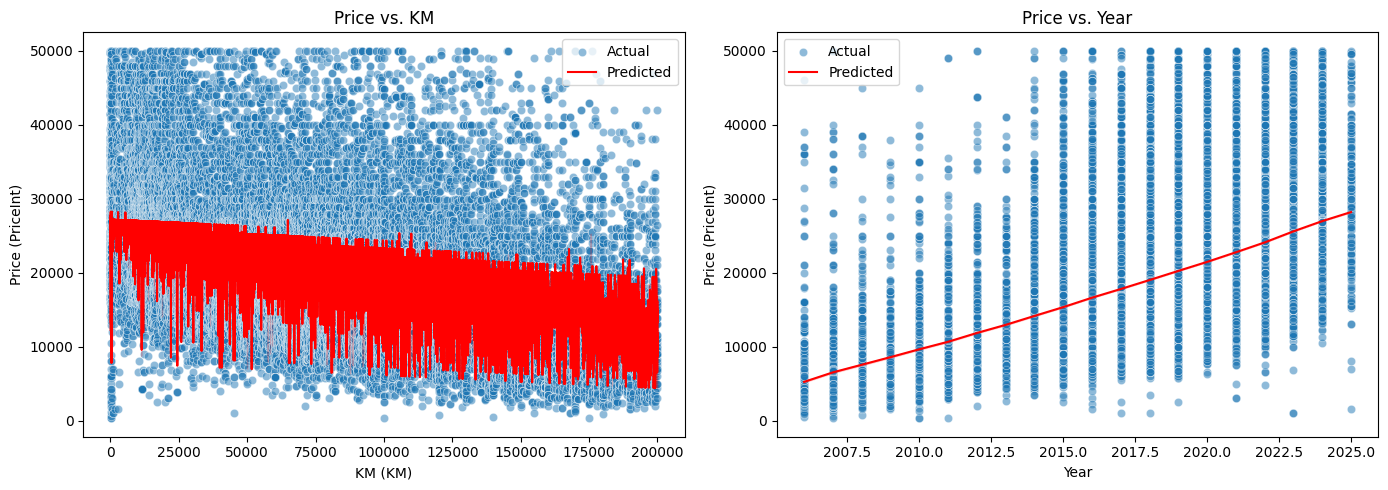

In [15]:
# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=df['KM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['KM'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[0])
axes[0].set_title('Price vs. KM')
axes[0].set_xlabel('KM (KM)')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[1])
axes[1].set_title('Price vs. Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()  # ✅ Ensures the first plot is displayed before moving to the next


In [10]:
# Create a grid for the regression plane
km_range = np.linspace(df["KM"].min(), df["KM"].max(), 20)
year_range = np.linspace(df["YEAR"].min(), df["YEAR"].max(), 20)
KM_grid, Year_grid = np.meshgrid(km_range, year_range)

# Compute predicted prices for the grid using the linear regression model
Z = model.intercept_ + model.coef_[0] * KM_grid + model.coef_[1] * Year_grid

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data points
ax.scatter(df["KM"], df["YEAR"], df["PriceInt"], c='blue', marker='o', alpha=0.5, label="Actual Prices")
ax.scatter(df["KM"], df["YEAR"], df["Predicted_Price"], c='black', marker='*', alpha=0.9, label="Predicted prices")


# Plot the regression plane
ax.plot_surface(KM_grid, Year_grid, Z, color='red', alpha=0.3, edgecolor='k')

# Labels and title
ax.set_xlabel('KM')
ax.set_ylabel('Year')
ax.set_zlabel('Price (PriceInt)')
ax.set_title('3D Regression Plane: Price vs KM & Year')

# Show the plot
plt.legend()
plt.show()


NameError: name 'model' is not defined

In [11]:
# Define independent variables and target variable
df['YEAR2'] = df[["YEAR"]] * df[['YEAR']]
X = df[["YEAR2", "YEAR", "KM"]]
y = df["PriceInt"]

# Train the regression model
modelSquared = LinearRegression()
modelSquared.fit(X, y)

print(modelSquared.coef_)

[ 3.18702012e+02 -1.28914722e+06 -1.29107555e-01]


KeyError: 'Predicted_Price'

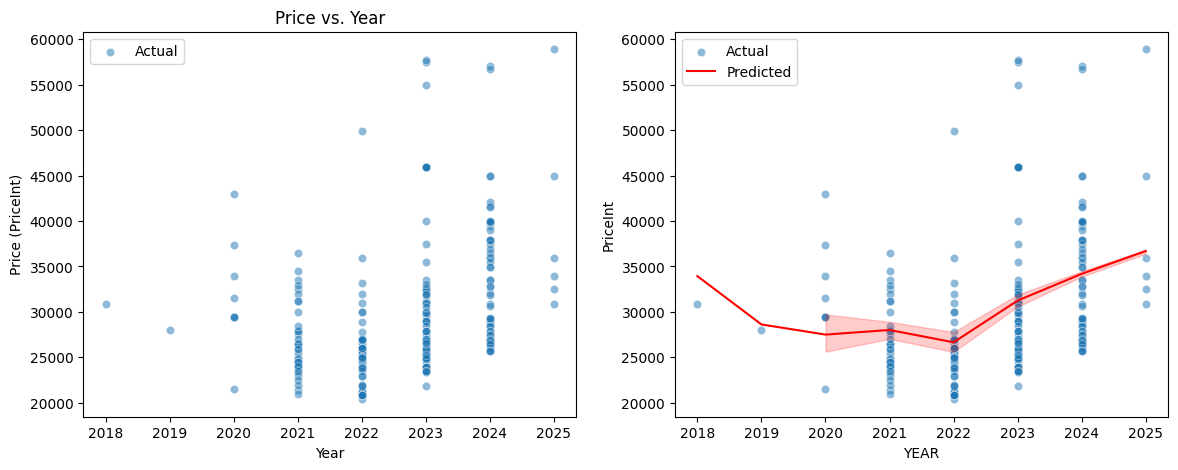

In [12]:
df['Predicted_Price_squared'] = modelSquared.predict(X)

# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price_squared'], color='red', label='Predicted', ax=axes[1])
axes[0].set_title('Price vs. Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[0])
axes[1].set_title('Price vs. Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()  # ✅ Ensures the first plot is displayed before moving to the next


[ -589.65757221 -1082.74698915]


C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_4764\1607169791.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\PORTATIL\OneDrive\Documentos\Projects\CochecitosScrapping\venvCars\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


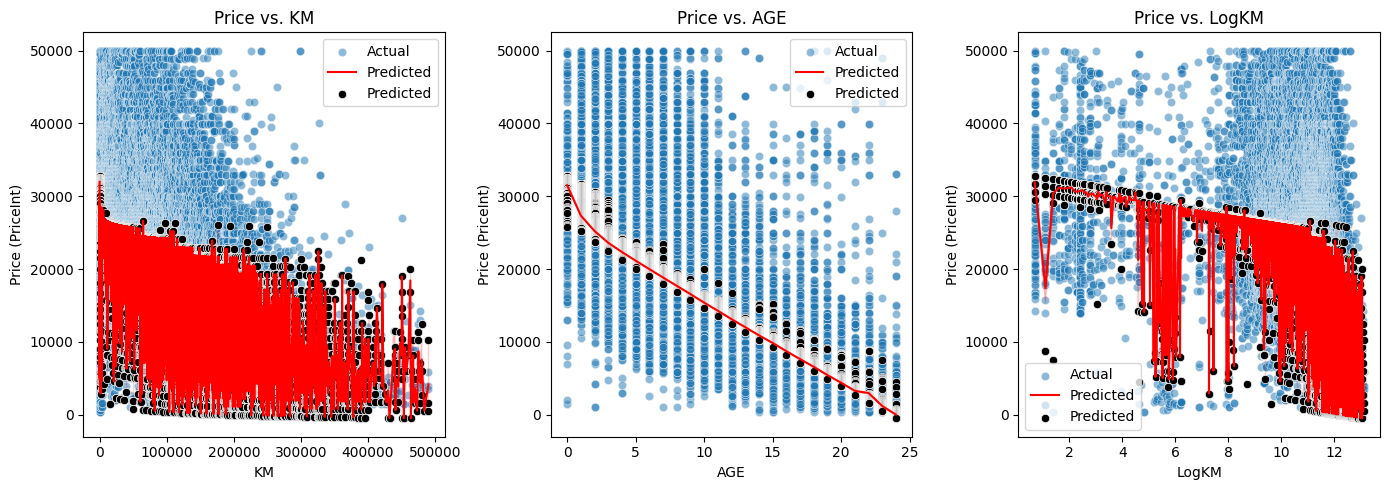

In [10]:
# Define independent variables and target variable
df['LogKM'] = np.log1p(df['KM'])  # Apply log transformation to KM
df['AGE'] = 2025 - df['YEAR']  # Assuming current year is 2025


X = df[["LogKM", "AGE"]]
y = df["PriceInt"]

# Train the regression model
modelLog = LinearRegression()
modelLog.fit(X, y)

print(modelLog.coef_)

df['Predicted_Price_log'] = modelLog.predict(X)

# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.scatterplot(x=df['AGE'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['AGE'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[1])
sns.scatterplot(x=df['AGE'], y=df['Predicted_Price_log'], color='black', label='Predicted', ax=axes[1])
axes[1].set_title('Price vs. AGE')
axes[1].set_xlabel('AGE')
axes[1].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['KM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['KM'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[0], sort=False)
sns.scatterplot(x=df['KM'], y=df['Predicted_Price_log'], color='black', label='Predicted', ax=axes[0])
axes[0].set_title('Price vs. KM')
axes[0].set_xlabel('KM')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['LogKM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[2])
sns.lineplot(x=df['LogKM'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[2], sort=False)
sns.scatterplot(x=df['LogKM'], y=df['Predicted_Price_log'], color='black', label='Predicted', ax=axes[2])
axes[2].set_title('Price vs. LogKM')
axes[2].set_xlabel('LogKM')
axes[2].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()


In [16]:
np.transpose([df.groupby("AGE")["PriceInt"].mean(), 
df.groupby("AGE")["PriceInt"].mean().diff()])

array([[39515.        ,            nan],
       [32970.43283582, -6544.56716418],
       [32527.76767677,  -442.66515905],
       [25739.56140351, -6788.20627326],
       [26834.75      ,  1095.18859649],
       [31953.125     ,  5118.375     ],
       [27990.        , -3963.125     ],
       [30900.        ,  2910.        ]])